<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLearning_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#更深的网络----ResNet

## ResNet要解决的问题
> &emsp;&emsp;退化问题：随着层数加深到一定程度后，越深的网络反而效果越差，并且并不是因为更深的网络造成了过拟合，也未必是因为梯度传播的衰减，因为已经有很多行之有效的方法来避免这个问题。

> &emsp;&emsp;在深度达到一定程度的时候,weight和bias都接近0,此时某一深层的output几乎为0,这样当bp的时候,很难更新weight和bias,不利于学习,但是通过残差块,这一层output+前一层的input作为下一层的input,这样通往下一层的weight和bias不至于为0,使得bp继续进行下去,继续更新weight和bias.(个人理解,不对请指出),貌似这是梯度消失,通过BN可以解决.
![例子](http://pan.anderd.com/download/6156d12aa126c5003fc5a55e)

## 先备知识

> 残差：是指预测值和观测值之间的差异，注意与误差的区别，误差是指观测值和真实值之间的差异。

## 残差块
![ResBlock](http://pan.anderd.com/download/6156d503302257003f390e35)

> &emsp;&emsp;如图假设我们的原始输⼊为x，而希望学出的理想映射为f(x)（作为上⽅激活函数的输⼊）。左图虚线框中的部分需要直接拟合出该映射f(x)，而右图虚线框中的部分则需要拟合出残差映射f(x)−x。残差映射在现实中往往更容易优化。ResNe模型中大量使用了一些相同的模块来搭建更深的网络，最后得到的模型在性能上却有不俗的表现，其中一个非常关键的因素就是模型累加的模块并非简单的单输入单输出的结构，而是一种设置了附加关系的新结构，这个附加关系就是恒等映射（Identit Mapping），这个新结构就是残差网络结构.

> &emsp;&emsp;事实证明，残差模块进行的这个简单的加法并不会给整个ResNet模型增加额外的参数和计算量.却能加快模型的训练速度，提升模型的训练效果;另外，在我们搭建的ResNet模型的深度加深时，使用残差模块的网络结构不仅不会出现模型退化问题,性能反而有所提升.

> &emsp;&emsp;这里需要注意附加的恒等映射关系的两种不同的使用情况，残差模块的输入数据若和输出结果的维度一致，则直接相加；若维度不一致，则先进行线性投影，在得到一致的维度后，再进行相加或者对维度不一致的部分使用0填充.

In [23]:
!pip install d2l

In [ ]:
#残差块的实现,首先ResNet沿用了VGG的完整的3x3卷积层设计.残差块里首先有两个相同输出通道的3x3卷积层,每个卷积层后接⼀个批量归⼀化层和ReLU激活函数。

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
  def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)#输入输出形状不变的卷积层
    self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self,X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)
# 此代码⽣成两种类型的⽹络：
#⼀种是在use_1x1conv=False、应⽤ReLU⾮线性函数之前，将输⼊添加到输出。
#另⼀种是在use_1x1conv=True时，添加通过1×1卷积调整通道和分辨率。


![两种网络](http://pan.anderd.com/download/6156ea8d9ca0c6003f2d0212)

In [ ]:
#输入和输出形状一样的情况
blk = Residual(3,3)
X = torch.rand(4,3,6,6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [ ]:
#我们可以增加输出通道的同时减版输出的高宽
blk = Residual(3,6,use_1x1conv=True,strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型


In [ ]:
#前两层与GooLeNet中的一样,不同之处在于ResNet每个卷积层后加了BN
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

&emsp;&emsp;ResNet使⽤4个由残差块组成的模块，每个模块使⽤若干个同样输出通道数的残差块。第⼀个模块的通道数同输⼊通道数⼀致。由于之前已经使⽤了步幅为2的最⼤汇聚层，所以⽆须减小⾼和宽。之后的每个模块在第⼀个残差块⾥将上⼀个模块的通道数翻倍，并将⾼和宽减半。

In [ ]:
def resnet_block(input_channles,num_channles,num_residuals,first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channles,num_channles,use_1x1conv=True,strides=2))
    else:
      blk.append(Residual(num_channles,num_channles))
  return blk

In [ ]:
#接着在ResNet加⼊所有残差块，这⾥每个模块使⽤2个残差块。
b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3 = nn.Sequential(*resnet_block(64,128,2))
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))

In [ ]:
#最后与GooLeNet一样,加入全局平均汇聚层,以及全连接层输出
net = nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),nn.Linear(512,10))

&emsp;&emsp;每个模块有4个卷积层（不包括恒等映射的1×1卷积层）。加上第⼀个7×7卷积层和最后⼀个全连接层，共有18层。因此，这种模型通常被称为ResNet-18。通过配置不同的通道数和模块⾥的残差块数可以得到不同的ResNet模型.
![ResNet-18](http://pan.anderd.com/download/6156f11edfbe2a003f06123e)

In [ ]:
#同样我们来看看每一层形状
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 0.011, train acc 0.997, test acc 0.901
374.3 examples/sec on cuda:0


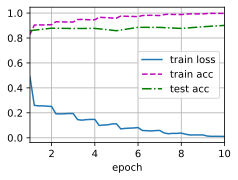

In [ ]:
#训练模型
lr,num_epochs,batch_size = 0.05,10,256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#DenseNet（稠密链接网络）
&emsp;&emsp;ResNet 将f分解为两部分：⼀个简单的线性项和⼀个更复杂的⾮线性项。那么再向前拓展⼀步，如果我们想将f拓展成超过两部分的信息呢,⼀种⽅案便是DenseNet。

![DenseNet1](http://pan.anderd.com/download/6157ba517c63dc003fe56437)

 ResNet（左）与 DenseNet（右）在跨层连接上的主要区别：使⽤相加和使⽤连结。
![DenseConnection](http://pan.anderd.com/download/6157c295c374ce003f76095d)

&emsp;&emsp;稠密⽹络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。前者定义如何连接输⼊和输出，而后者则控制通道数量，使其不会太复杂。

In [ ]:
#稠密块

import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels,num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels),nn.ReLU(),
      nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1))
#⼀个稠密块由多个卷积块组成，每个卷积块使⽤相同数量的输出信道。然而，在前向传播中，我们将每个卷积块的输⼊和输出在通道维上连结。

In [ ]:
class DenseBlock(nn.Module):
  def __init__(self,num_convs,input_channels,num_channels):
    super().__init__()
    layer = []
    for i in range(num_convs):
      layer.append(conv_block(num_channels * i + input_channels,num_channels))
    self.net = nn.Sequential(*layer)
  def forward(self,X):
    for blk in self.net:
      Y = blk(X)
      X = torch.cat((X,Y),dim=1)#连接通道维度上每个块的输⼊和输出
    return X

In [ ]:
blk = DenseBlock(2,3,10)
X = torch.randn(4,3,8,8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [ ]:
#过渡层，由于每个稠密块都会带来通道数的增加，使⽤过多则会过于复杂化模型。而过渡层可以⽤来控制模型复杂度。
#它通过1×1卷积层来减小通道数，并使⽤步幅为2的平均汇聚层减半⾼和宽，从而进⼀步降低模型复杂度。
def transition_block(input_channels,num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels),nn.ReLU(),
      nn.Conv2d(input_channels,num_channels,kernel_size=1),
      nn.AvgPool2d(kernel_size=2,stride=2))

In [ ]:
blk = transition_block(23,10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [ ]:
#DenseNet模型
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1))#DenseNet ⾸先使⽤同 ResNet ⼀样的单卷积层和最⼤汇聚层。

In [ ]:
num_channels,growth_rate = 64,32
num_convs_in_dense_blocks = [4,4,4,4]
blks = []
for i,num_convs in enumerate(num_convs_in_dense_blocks):
  blks.append(DenseBlock(num_convs,num_channels,growth_rate))
  #上一层周密块的输出通道
  num_channels += num_convs * growth_rate
  #在稠密块之间添加⼀个转换层，使通道数量减半
  if i != len(num_convs_in_dense_blocks)-1:
    blks.append(transition_block(num_channels,num_channels // 2))
    num_channels = num_channels // 2

net = nn.Sequential(
    b1,*blks,
    nn.BatchNorm2d(num_channels),nn.ReLU(),
    nn.AdaptiveAvgPool2d((1,1)),#与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。
    nn.Flatten(),
    nn.Linear(num_channels,10))

loss 0.144, train acc 0.947, test acc 0.898
949.8 examples/sec on cuda:0


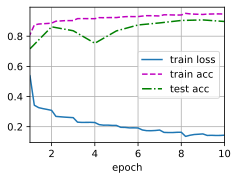

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

##小结
* 在跨层连接上，不同于ResNet中将输⼊与输出相加，稠密连接⽹络（DenseNet）在通道维上连结输⼊与输出。
* DenseNet的主要构建模块是稠密块和过渡层。
* 在构建DenseNet时，我们需要通过添加过渡层来控制⽹络的维数，从而再次减少信道的数量。

#计算机视觉
&emsp;&emsp;研究了计算机视觉中常⽤的各种卷积神经⽹络，并将它们应⽤到简单的图像分类任务中。改进模型泛化的⽅法有两种：图像增⼴和微调
##图像增广
&emsp;&emsp;图像增⼴在对训练图像进⾏⼀系列的随机变化之后，⽣成相似但不同的训练样本，从而扩⼤了训练集的规模。此外，应⽤图像增⼴的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提⾼模型的泛化能⼒。


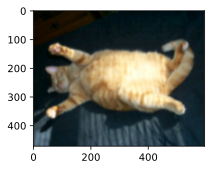

In [24]:
#图像增广
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('/home/cat1.jpg')
d2l.plt.imshow(img);


In [25]:
#⼤多数图像增⼴⽅法都具有⼀定的随机性。为了便于观察图像增⼴的效果，我们下⾯定义辅助函数 apply 。
#此函数在输⼊图像 img 上多次运⾏图像增⼴⽅法 aug 并显⽰所有结果。
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
  Y = [aug(img)for _ in range(num_rows*num_cols)]
  d2l.show_images(Y,num_rows,num_cols,scale=scale)

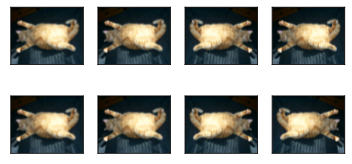

In [26]:
apply(img,torchvision.transforms.RandomHorizontalFlip())#有50%的概率使图像向左或向右翻转

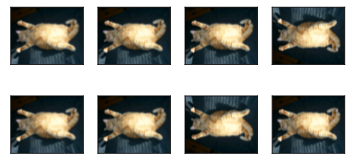

In [27]:
apply(img,torchvision.transforms.RandomVerticalFlip())#使图像有50%上下翻转

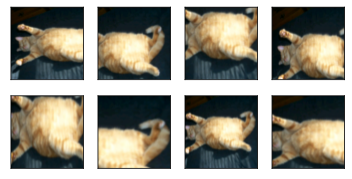

In [28]:
#在我们使⽤的⽰例图像中，猫位于图像的中间，但并⾮所有图像都是这样。我们可以通过对图像进⾏随机裁剪，使物体以不同的⽐例出现
#在图像的不同位置。这也可以降低模型对⽬标位置的敏感性。
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200,200),scale=(0.1,1),ratio=(0.5,2))#随机剪裁一个面积为原始面积的10%到100%的区域，该区域高宽比从0.5到2之间随即取值，区域的宽度和⾼度都被缩放到200像素。
apply(img,shape_aug)

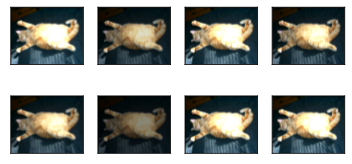

In [29]:
#改变颜色，这有4个方面：亮度，对比度，饱和度，和色调
apply(img,torchvision.transforms.ColorJitter(
    brightness=0.5,contrast=0,saturation=0,hue=0))#随机更改图像的亮度，随机值为原始图像的50%(1−0.5)到150%（1+0.5）之间。

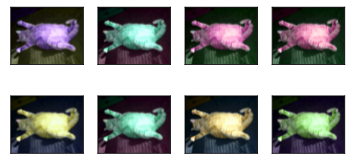

In [30]:
#随机改变色调
apply(img,torchvision.transforms.ColorJitter(hue=0.5))


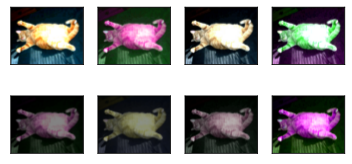

In [31]:
#还可以同时改变四种方面
color_aug = torchvision.transforms.ColorJitter(brightness=0.5,contrast=0.4,saturation=0.6,hue=0.3)
apply(img,color_aug)

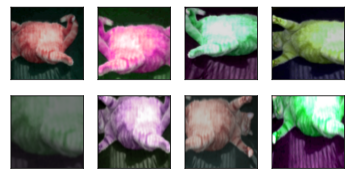

In [33]:
#结合多种图像增广方法
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),color_aug,shape_aug])
apply(img,augs)

Files already downloaded and verified


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f58a394b7d0>,
      dtype=object)

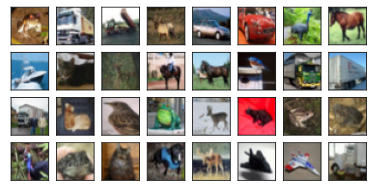

In [34]:
#使用图像增广来训练模型，我们使⽤CIFAR-10数据集，CIFAR-10数据集中对象的颜⾊和⼤小差异更明显。
all_images = torchvision.datasets.CIFAR10(train=True,root="../data",download=True)
d2l.show_images([all_images[i][0] for i in range(32)],4,8,scale=0.8)

In [35]:
train_augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),torchvision.transforms.ToTensor()])#使⽤ ToTensor 实例将⼀批图像转换为深度学习框架所要求的格式即形状为（批量⼤小，通道数，⾼度，宽度）的32位浮点数，取值范围为0到1。

test_augs = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()]#验证集不做增广
)

In [43]:
#定义⼀个辅助函数，以便于读取图像和应⽤图像增⼴
def load_cifar10(is_train,augs,batch_size):
  dataset = torchvision.datasets.CIFAR10(
      root="../data",train=is_train,
      transform=augs,download=True)
  dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,
                                           shuffle=is_train,num_workers=d2l.get_dataloader_workers())
  return dataloader

In [44]:
#多GPU训练
def train_batch_ch13(net, X, y, loss, trainer, devices):
  if isinstance(X, list):
    # 微调BERT中所需（稍后讨论）
    X = [x.to(devices[0]) for x in X]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

In [47]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                  devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                          legend=['train loss', 'train acc', 'test acc'])
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    # 4个维度：储存训练损失，训练准确度，实例数，特点数
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3],None))
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {metric[0] / metric[2]:.3f}, train acc '
    f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
    f'{str(devices)}')

In [45]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction="none")
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.170, train acc 0.941, test acc 0.846
240.1 examples/sec on [device(type='cuda', index=0)]


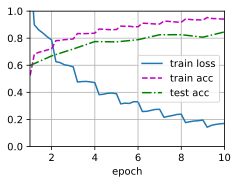

In [48]:
train_with_data_aug(train_augs, test_augs, net)

##小结
* 图像增⼴基于现有的训练数据⽣成随机图像，来提⾼模型的概化能⼒。
* 为了在预测过程中得到确切的结果，我们通常对训练样本只进⾏图像增⼴，而在预测过程中不使⽤随机操作的图像增⼴。
* 深度学习框架提供了许多不同的图像增⼴⽅法，这些⽅法可以被同时应⽤。

#微调
##步骤
>1. 在源数据集（例如 ImageNet 数据集）上预训练神经⽹络模型，即 源模型。
2. 创建⼀个新的神经⽹络模型，即 ⽬标模型。这将复制源模型上的所有模型设计及其参数，但输出层除外。我们假定这些模型参数包含从源数据集中学到的知识，这些知识也将适⽤于⽬标数据集。我们还假设源模型的输出层与源数据集的标签密切相关；因此不在⽬标模型中使⽤该层。
3. 向⽬标模型添加输出层，其输出数量是⽬标数据集中的类别数。然后随机初始化该层的模型参数。
4. 在⽬标数据集（如椅⼦数据集）上训练⽬标模型。输出层将从头开始进⾏训练，而所有其他层的参数将
根据源模型的参数进⾏微调。

![微调](http://pan.anderd.com/download/615931f38a0d4c003f67487b)

> 当⽬标数据集⽐源数据集小得多时，微调有助于提⾼模型的泛化能⼒。

In [49]:
#演示微调：热狗识别，在⼀个小型数据集上微调 ResNet 模型，该数据集已在
#ImageNet 数据集上进⾏了预训练。这个小型数据集包含数千张包含热狗和不包含热狗的图像，我们将使⽤
#微调模型来识别图像中是否包含热狗。
%matplotlib inline

import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


In [50]:
#获取数据集
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL+'hotdog.zip','fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [51]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir,'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir,'test'))#读取训练集和验证集

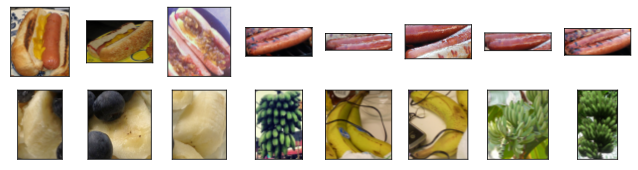

In [52]:
hotdogs = [train_imgs[i][0]for i in range(8)]#显示热狗和不是热狗的图片样例
not_hotdogs = [train_imgs[-i-1][0]for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs,2,8,scale=1.4);

In [53]:
#数据预处理

normalize = torchvision.transforms.Normalize(
    [0.485,0.456,0.406],[0.229,0.224,0.225])#使⽤三个RGB通道的均值和标准偏差，以标准化每个通道

train_augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(224),#从图像中裁切随机⼤小和随机⻓宽⽐的区域，然后将该区域缩放为 224 × 224 输⼊图像。
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor(),normalize])
test_augs = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(256),#测试过程中，我们将图像的⾼度和宽度都缩放到 256 像素，然后裁剪中央 224 × 224 区域作为输⼊
     torchvision.transforms.CenterCrop(224),
     torchvision.transforms.ToTensor(),
     normalize])

In [54]:
pretrained_net = torchvision.models.resnet18(pretrained=True)#使⽤在 ImageNet 数据集上预训练的 Resnet-18 作为源模型。

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [55]:
pretrained_net.fc#预训练的源模型实例包含许多特征层和⼀个输出层 fc。此划分的主要⽬的是促进对除输出层以外所有层的模型参数进⾏微调。下⾯给出了源模型的变量 fc。

Linear(in_features=512, out_features=1000, bias=True)

> &emsp;&emsp;在 ResNet 的全局平均池化后，全连接层汇集转换为 ImageNet 数据集的 1000 个类输出。之后，我们构建⼀个新的神经⽹络作为⽬标模型。它的定义⽅式与预训练源模型的定义⽅式相同，只是最终层中的输出数量被设置为⽬标数据集中的类数（而不是1000个）。

In [58]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features,2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [63]:
#微调模型
#变量输出中的模型参数是随机初始化的，通常需要更⾼的学习率才能从头开始训练。假设 Trainer 实例中
#的学习率为 1，我们将迭代中变量输出中模型参数的学习率设置为 10。
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,param_group=True):
  train_iter = torch.utils.data.DataLoader(
      torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
      batch_size=batch_size, shuffle=True)
  test_iter = torch.utils.data.DataLoader(
      torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
      batch_size=batch_size)
  devices = d2l.try_all_gpus()
  loss = nn.CrossEntropyLoss(reduction="none")
  if param_group:## 如果 `param_group=True`，输出层中的模型参数将使⽤⼗倍的学习率
    params_1x = [param for name, param in net.named_parameters()
      if name not in ["fc.weight", "fc.bias"]]
    trainer = torch.optim.SGD([{'params': params_1x},{'params': net.fc.parameters(),'lr': learning_rate * 10}],lr=learning_rate, weight_decay=0.001)
  else:
    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,weight_decay=0.001)
  d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

loss 0.147, train acc 0.944, test acc 0.948
179.4 examples/sec on [device(type='cuda', index=0)]


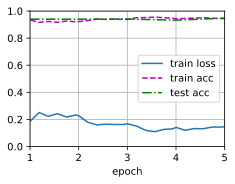

In [65]:
train_fine_tuning(finetune_net, 5e-5)#使⽤较小的学习率，通过微调预训练获得的模型参数。

loss 0.358, train acc 0.847, test acc 0.809
179.5 examples/sec on [device(type='cuda', index=0)]


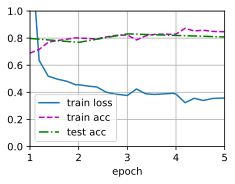

In [66]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

> 微调模型往往表现更好，因为它的初始参数值更有效。

##小结
* 迁移学习将从源数据集中学到的知识“迁移”到⽬标数据集，微调是迁移学习的常⻅技巧。
* 除输出层外，⽬标模型从源模型中复制所有模型设计及其参数，并根据⽬标数据集对这些参数进⾏微调。但是，⽬标模型的输出层需要从头开始训练。
* 通常，微调参数使⽤较小的学习率，而从头开始训练输出层可以使⽤更⼤的学习率。